In [3]:
from IPython.html.services.config import ConfigManager
from IPython.utils.path import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))
cm.update('livereveal', {
              'theme': 'sky',
              'transition': 'zoom',
              'start_slideshow_at': 'selected',
})

/home/ivan/miniconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/ivan/miniconda2/lib/python2.7/site-packages/IPython/utils/path.py:282: UserWarning: locate_profile has moved to the IPython.paths module
  warn("locate_profile has moved to the IPython.paths module")


{u'scroll': True,
 u'start_slideshow_at': 'selected',
 u'theme': 'sky',
 u'transition': 'zoom'}

# Lecture 14. Wavelets

## (Approximate) Syllabus
- **Week 1:** Intro & basic integral equations (turning PDEs into IEs, typical kernels, Nystrom, collocation, Galerkin, quadrature for singular/hypersingular integrals).
- **Week 2:** Translation-invariant kernels and convolutions, FFT. Concept of close and far interactions precorrected FFT. Barnes-Hut method
- **Week 3:**  Fast multipole methods. Algebraic analogue of fast multipole method, hierarchical matrices
- **Week 4:**  Multigrid methods, domain decomposition, sparse grids
- **Week 5:** Wavelets & Tensors

## Previous lecture
- Sparse grids

## Todays lecture

- Wavelets

## Standard basis functions

Standard basis functions are local, and if we have a global function (for example, $f(x) = 1)$ the coefficients in the expansion

$$f(x) = \sum_{i=1}^N c_i \phi_i(x).$$

No coefficients can be omittied, i.e. $c_i = f(x_i) = 1$, and the vector is non-sparse.

The idea of **wavelets** is to find a right basis (instead of piecewise-linears) where the coefficients will be **pseudo-sparse**.

## Nested subspaces

Let  $V_k = \{ \mathrm{Span}(\phi^{(k)}_1, \ldots, \phi^{(k)}_{N_k}) \}$ - be the subspace of piecewise-linear functions on a grid.


We have obvious connection

$$V_1 \subset V_2 \subset \ldots \subset V_k.$$


For example, constant and linear functions are in $V_1$, i.e. defined by $2$ coefficients.

But the vector in $V_k$ does not feel it!

## Separation into "good" and "bad" subspaces

The **key idea** is to separate the subspace into "fine" and coarse part:

$$V_k = V_{k-1} \oplus W_k,$$

where $W_k$ is called **wavelet space**. The subspace $W_k$ is selected in a way that coefficients in the expansion 

$$v_k = v_{k-1} + w_{k}$$

the vector $w_k$ is small for **good** functions (i.e. polynomials),

for example, 

$$w_k \perp \mathcal{P}.$$

Another option is to require orthogonality:

$$V_{k-1} \perp W_k,$$

but this can not be done for arbitrary nested subspaces (special subspaces have to be designed).

## Haar wavelets

The simplest and the oldest (but yet quite effective) wavelet spaces are **Haar wavelets**.

They are based on piecewise-constant functions.

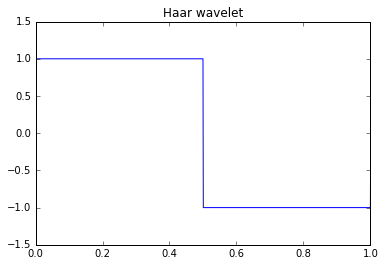

In [7]:
%matplotlib inline
import numpy as np
import pywt
import matplotlib.pyplot as plt

w = pywt.Wavelet('Haar')
phi, psi, x = w.wavefun(level=10)

fig, ax = plt.subplots()
ax.set_xlim(0,1)
ax.plot(x, psi)
ax.set_title('Haar wavelet')

## General scheme

So, we represent the function instead of two constant functions on $[0, 0.5]$ and $[0.5, 1.0]$,

by a single constant function on $[0, 1]$ and one Haar wavelet.

## Multilevel scheme

$$V_k = V_{k-1} + W_k = V_{k-2} + W_{k-1} + W_k = W_1 + W_2 + \ldots W_k.$$

We only store the **details** coefficients. 

At this step, no information is lost. However, the details coefficient is **pseudo-sparse**, i.e. many of the entries can be replaced by the small entries.

## Discrete wavelet transform

The discrete wavelet transform comes from the transformation of the **coefficients** of the vector with respect to $V_k$ and the set of wavelet spaces:

$$f = V_k p, \quad g = W p.$$

In the simplest Haar wavelet case this also has a very simple look:

## Discrete Haar wavelet transform

Given a vector $x$, we split it into "odd" and "even" components and have

$$x'_{2i} = \frac{1}{\sqrt{2}} \left(x_{2i} + x_{2i-1}\right), \quad x'_{2i-1} = \frac{1}{\sqrt{2}}\left(x_{2i} - x_{2i-1}\right).$$

Note what happens: we compute differents and sums of nearby points. The **wavelet coefficients** are correction coefficients, but no information is lost.

## Multilevel transform

The Haar wavelet transform is then applied recursively:

- We compute sums and differences
- Arrange sums as the first $n/2$ entries of the vector
- We apply Haar transform to the first $n/2$ entries


## Properties of the Haar wavelet transform

$$y = W c, $$

$W$ is an orthogonal matrix, and it transforms "smooth functions" to "pseudo-sparse".

I.e., if $c$ is constant, it will contain only $1$ non-zero element.

(it is also known as one **zero moment**).

## Constructing wavelets

There are two basic constructions of discrete wavelet transforms:

- Based on continious wavelet representation 
- Based on the discrete construction and so-called "lifting schemes".

Another question is, how this can be used in fast solvers. Again, several options:

- Using wavelet basis (to be defined in a second) to represent solution
- Using Discrete Wavelet Transform to sparsify solution and/or the matrix (in case of integral equations).

## Classical wavelet basis construction

Classica wavelet basis construction is based on **shifts** and **scaling** of a single function.

Indeed, the Fourier expansion is based on the expression of a signal as a linear combination of complex exponents:

$$f(x) = \sum_{k} c_k e^{ikx},$$

i.e. all the basis functions are **scales** of the same mother function $$e^{ix}$$.

The problem with it is well-known: it has **global support** and if we add a noise or singularity at $1$ point, the decay of the coefficients will be bad.

A nice introduction is given by [G. Strang](http://www4.ncsu.edu/~gremaud/REU/strang.pdf)

array([  1.00000000e+00,   3.18621539e-01,   3.18621539e-01, ...,
         9.77521707e-04,   9.77521707e-04,   9.77517107e-04])

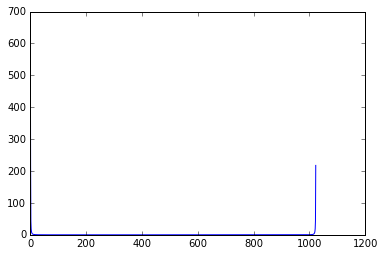

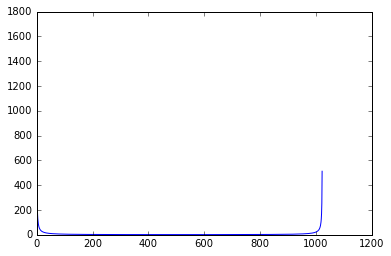

In [21]:
import numpy as np

n = 1024

t = np.linspace(0, np.pi, n)

f = np.sin(t)
plt.plot(np.abs(np.fft.fft(f)))
f = t
plt.figure()

q1 = np.abs(np.fft.fft(f))
plt.plot(np.abs(np.fft.fft(f)))
q2 = np.sort(q1)[::-1]
q2 / q2[0]

## Dilatation and translation

The idea of wavelet basis is to use **local support** basis functions. Then, scaling-only is not enough, and **shifting** is required as well. This is called **dilatation** and **translation**.

The basis set is then defined as the set of all functions of the form

$$W_{kl} = W(2^k x - l),$$

where $W$ is called **mother function**

This is not yet the wavelet basis: it only allows us to generate the sequence of nested subspaces.

The orthogonality of the basis is not easy to fullfil (and we need orthogonal basis).



## Orthogonality

To ensure orthogonality, the function $W$ has to be selected in such a way that it is orthogonal to all its dilatation and transalations:

$$\int W(x) W(2^k x - l) dx = 0.$$

## Scaling function

The wavelets give a multiresolution basis for a sequence of nested subspaces. How they are defined?

This subspaces are typically generated by the dilatation (which is a transform $\phi \rightarrow \phi(2x)$0 and translation of a scaling function $\phi(x)$.

To make the subspaces nested, we have the equation

$$\phi(x) = \sum_k c_k \phi(2x -k),$$

which is called **dilatation equation**

The sufficient condition comes from the integration of both parts and has the form

$$\sum_k c_k = 2.$$

## Examples of dilatation equations

Delta function has $c_0 = 2$, $\delta(2x) = 2 \delta(x)$.

The hat function has $c_0 = 1, c_1 = c_{-1} = \frac{1}{2}.$

## Important example: Daubechies wavelet
One of the most important examples has

$$c = \left(\frac{1}{4}(1 + \sqrt{3}), \frac{1}{4}(3 + \sqrt{3}), \frac{1}{4}(3 - \sqrt{3}), \frac{1}{4}(1 - \sqrt{3})\right).$$

Note, not very smooth!

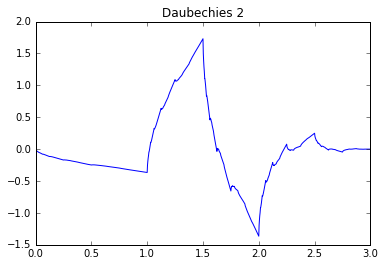

In [31]:
%matplotlib inline
import numpy as np
import pywt
import matplotlib.pyplot as plt
pywt.wavelist()
w = pywt.Wavelet('db2')
phi, psi, x = w.wavefun(level=10)

fig, ax = plt.subplots()
#ax.set_xlim(0,1)
ax.plot(x, psi)
ax.set_title('Daubechies 2')

## Solving dilatation equation

The scaling function is uniquely defined by the coefficients.

A popular construction is taking the Fourier Transform of both sides, which gives

$$\widehat{\psi}(\xi) = P\left(\frac{\xi}{2}\right) \widehat{\psi}\left(\frac{\xi}{2}\right),$$

where 

$$P(\xi) = \frac{1}{2} \sum_k c_k e^{i k \xi}.$$

Applying this recursively, we get a product representatation of $\psi$.

## Conditions on coefficients

The whole analysis is defined by the coefficients $c_k$.

The crucial points are:

1. Polynomials $1, \ldots, x^p$ are linear combination of translates $\phi(x - k)$. 
2. $$\sum_{k} (-1)^k k^m c_k = 0, \quad m = 0, \ldots, p-1$$
3. Wavelet function $W(x)$, defined as $W(x) = \sum_k (-1)^k c_{1-k} \phi(2x -k)$, has first $p$ moments zero.
4. (Condition O.) Orthogonality of the wavelets is $\sum_k c_k c_{k - 2m} = 2 \delta_{0m}.$

Construction of orthogonal bases is non-trivail, and D2 wavelets are the prominent example.

I would even consider this as a "miracle" as well.

## Multidimensional construction

So far, we have considered only one-dimensional case.

In two dimensions, the standard approach is to use tensor product basis functions of one-dimensional basis functions.

## Finite domains

The theory of Daubechies is based on the infinite domain, and translations are for the whole domain.

Typically, we work on fixed intervals, and we will have to introduce "boundary conditions" which are often done using **periodization**. A simpler approach (also applicable for much more complicated domains) was proposed by W. Sweldens and is called **lifting scheme**.

## Lifting scheme

The idea of the lifting scheme starts from a given **coarse** $\widetilde{\phi}_i$ and **fine** $\phi_i$ basis functions.

Suppose there are **twice many** fine functions rather than coarse functions. 

Then,

we can introduce a subset of the fine functions that complement the coarse space, and **correct them** for arbitrary coarse functions,

$$\phi'_{2i} = \phi_{2i} - \sum_{j \in N(i)} \alpha_j \widetilde{\phi}_j,$$

and to maintain locality, we require the the sum goes near the given basis function.

This still gives the basis for the "wavelet space".

The coefficients $\alpha_j$ are then selected either to make the "wavelet space" more orthogonal to the coarse space, 

or to make it have the required number of zero moments.

## Wavelet methods for PDE

Wavelet methods can produce optimal discretizations for PDEs, see

[Wavelet methods for PDEs — some recent developments by 
Wolfgang Dahmen](http://www.sciencedirect.com/science/article/pii/S0377042700005112/pdfft?md5=4899ddde2303b2f1129537a6d59a6a4f&pid=1-s2.0-S0377042700005112-main.pdf)

Just one result: the Laplace operator in the wavelet basis is equivalent to the diagonal matrix.

Why: in the Fourier basis it is a diagonal matrix, in the wavelet basis it is "diagonal" on each multiresolution level.

## Wavelet methods for integral equations

For integral equations, wavelet methods are often used to compress the matrix:

$$\widehat{A} = W A W^{\top},$$

and $\widehat{A}$ is **pseudosparse*.

## Reading

There is an extremely simple & nice book [Wavelets for computer graphics, by Eric Stollnitz, Tony DeRose, David Salesin](http://grail.cs.washington.edu/projects/wavelets/) with a Russian  translation, 

which gives a very gentle introduction to the concept of multiresolution analysis and discrete wavelet transforms.

## Summary
- Idea of multiresolution analysis
- Haar wavelet transform
- Dilatation equation
- Lifting scheme

## Next lecture
- Tensors

In [40]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()b
    return HTML(styles)
css_styling()